# Railspace Text + Patch Data Exploration

This notebook provides some examples of how to load and visualise the text outputs of MapReader. 

We focus on the geography of railspace and labels describing railspace on maps.

----

In [1]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
from collections import Counter
from tqdm import tqdm
from shapely import from_wkt, to_wkt

# 1. Load data

In [2]:
# 1.1 Load the patch predictions for railspace model

predictions = pd.read_csv("../post_processed_railspace_predictions_patch_df.csv", index_col=0)
predictions["geometry"] = predictions["geometry"].apply(from_wkt)
predictions = gpd.GeoDataFrame(predictions, geometry="geometry", crs="EPSG:4326")

predictions.head(3)

,parent_id,image_path,shape,pixel_bounds,coordinates,crs,geometry,predicted_label,pred,conf,min_x,min_y,max_x,max_y,new_predicted_label,new_pred
image_id,,,,,,,,,,,,,,,,
patch-0-0-134-134-#map_95470395.png#.png,map_95470395.png,/bask/projects/v/vjgo8416-dataculture/mapreade...,"(134, 134, 4)","(0, 0, 134, 134)","(-0.230712890625, 51.49416936411413, -0.229275...",EPSG:4326,"POLYGON ((-0.22928 51.49417, -0.22928 51.49506...",no,0,0.962000,0,0,134,134,no,0.0
patch-0-134-134-268-#map_95470395.png#.png,map_95470395.png,/bask/projects/v/vjgo8416-dataculture/mapreade...,"(134, 134, 4)","(0, 134, 134, 268)","(-0.230712890625, 51.49327399808456, -0.229275...",EPSG:4326,"POLYGON ((-0.22928 51.49327, -0.22928 51.49417...",railspace,1,0.999944,0,134,134,268,railspace,1.0
patch-0-268-134-402-#map_95470395.png#.png,map_95470395.png,/bask/projects/v/vjgo8416-dataculture/mapreade...,"(134, 134, 4)","(0, 268, 134, 402)","(-0.230712890625, 51.492378632055, -0.22927522...",EPSG:4326,"POLYGON ((-0.22928 51.49238, -0.22928 51.49327...",no,0,0.999654,0,268,134,402,no,0.0


In [3]:
# filter for only railspace predictions
predictions = predictions[predictions["new_predicted_label"]=="railspace"]

In [4]:
# 1.2 load the geojson with spotted text

# we use the file that has been converted to point data
spotted_text = gpd.read_file("../geo_predictions_deduplicated_point.json")
spotted_text.to_crs(epsg=27700, inplace=True)
spotted_text.shape


(463769, 7)

In [5]:
#1.3 view spotted_text df

spotted_text.head(3)

,image_id,crs,text,score,patch_id,duplicate,geometry
0,map_95470395.png,EPSG:4326,GARDENS,0.97,patch-0-0-1000-1000-#map_95470395.png#.png,False,POINT (523626.732 178792.734)
1,map_95470395.png,EPSG:4326,Soh.,0.96,patch-0-0-1000-1000-#map_95470395.png#.png,False,POINT (523628.406 178550.555)
2,map_95470395.png,EPSG:4326,ROAD,0.98,patch-0-0-1000-1000-#map_95470395.png#.png,False,POINT (523372.540 178126.047)


In [6]:
#1.4 clean spotted_text 

spotted_text['text_cleaned'] = spotted_text['text'].apply(lambda x: x.lower().strip().replace("(", "").replace(")", ""))

## 2. Filter labels

Here we discard the following labels
- those starting and ending with #
- those starting < or ending with >
- numbers after stripping the dot

The we lowercase all labels.

In [7]:
# 2.1 filter spotted to reduce noise labels

def filter_labels(w):
	return (w.endswith('#') or w.startswith('#') or w.endswith('>') or w.startswith('<') or w.strip('.').isdigit())

spotted_text_filtered = spotted_text[~spotted_text.apply(lambda x: filter_labels(x['text_cleaned']), axis=1)]

In [8]:
# 2.2 remove duplicates

spotted_text_filtered = spotted_text_filtered.drop_duplicates(subset=['patch_id','geometry','text']).reset_index(drop=True)
spotted_text_filtered.shape

(210429, 8)

In [9]:
# 2.3 print the shape of the dataframes

print(f"Railspace predictions shape: {predictions.shape}")
print(f"Spotted text original shape: {spotted_text.shape} filtered {spotted_text_filtered.shape}")

Railspace predictions shape: (29395, 16)
Spotted text original shape: (463769, 8) filtered (210429, 8)


In [10]:
# 2.4 count text_cleaned values

spotted_text_filtered.text_cleaned.value_counts().head(10)

text_cleaned
b.      18026
m.      14030
f.       9671
p.       9335
road     8580
p        7805
s.       3226
farm     2573
b        2385
w        2271
Name: count, dtype: int64

## 3. Filter patches

In [11]:
# 3.1 Retain patch predictions for maps that are in the spotted text data

text_map_ids = list(spotted_text.image_id.unique())
print('number of maps', len(text_map_ids))

# filter to those maps for which we have spotted text
predictions_red = predictions[predictions['parent_id'].isin(text_map_ids)]
predictions_red.shape,predictions.shape


number of maps 329


((29395, 16), (29395, 16))

In [12]:
# 3.4 convert the projection to the same as the spotted text

predictions_red.to_crs(epsg=27700, inplace=True) # 27700, British National Grid


In [13]:
predictions_red.reset_index(inplace=True)

In [14]:
# 3.2 add geometry to the patch predictions

predictions_red["polygon"] = predictions_red["geometry"]
predictions_red["centroid"] = predictions_red["geometry"].centroid

predictions_red.reset_index(drop=True, inplace=True)

In [15]:
# 3.3 View predictions_red

predictions_red.head()

,image_id,parent_id,image_path,shape,pixel_bounds,coordinates,crs,geometry,predicted_label,pred,conf,min_x,min_y,max_x,max_y,new_predicted_label,new_pred,polygon,centroid
0,patch-0-134-134-268-#map_95470395.png#.png,map_95470395.png,/bask/projects/v/vjgo8416-dataculture/mapreade...,"(134, 134, 4)","(0, 134, 134, 268)","(-0.230712890625, 51.49327399808456, -0.229275...",EPSG:4326,"POLYGON ((523024.806 178633.966, 523022.398 17...",railspace,1,0.999944,0,134,134,268,railspace,1.0,"POLYGON ((523024.806 178633.966, 523022.398 17...",POINT (522973.703 178682.544)
1,patch-0-4422-134-4556-#map_95470395.png#.png,map_95470395.png,/bask/projects/v/vjgo8416-dataculture/mapreade...,"(134, 134, 4)","(0, 4422, 134, 4556)","(-0.230712890625, 51.46462228513854, -0.229275...",EPSG:4326,"POLYGON ((523101.859 175447.771, 523099.452 17...",railspace,1,1.000000,0,4422,134,4556,railspace,1.0,"POLYGON ((523101.859 175447.771, 523099.452 17...",POINT (523050.725 175496.348)
2,patch-0-4556-134-4608-#map_95470395.png#.png,map_95470395.png,/bask/projects/v/vjgo8416-dataculture/mapreade...,"(134, 134, 4)","(0, 4556, 134, 4608)","(-0.230712890625, 51.46427482966438, -0.229275...",EPSG:4326,"POLYGON ((523102.793 175409.133, 523101.859 17...",railspace,1,0.999994,0,4556,134,4608,railspace,1.0,"POLYGON ((523102.793 175409.133, 523101.859 17...",POINT (523052.395 175427.245)
3,patch-134-134-268-268-#map_95470395.png#.png,map_95470395.png,/bask/projects/v/vjgo8416-dataculture/mapreade...,"(134, 134, 4)","(134, 134, 268, 268)","(-0.22927522659301758, 51.49327399808456, -0.2...",EPSG:4326,"POLYGON ((523124.605 178636.381, 523122.195 17...",railspace,1,1.000000,134,134,268,268,railspace,1.0,"POLYGON ((523124.605 178636.381, 523122.195 17...",POINT (523073.501 178684.958)
4,patch-134-4556-268-4608-#map_95470395.png#.png,map_95470395.png,/bask/projects/v/vjgo8416-dataculture/mapreade...,"(134, 134, 4)","(134, 4556, 268, 4608)","(-0.22927522659301758, 51.46427482966438, -0.2...",EPSG:4326,"POLYGON ((523202.656 175411.548, 523201.721 17...",railspace,1,0.999987,134,4556,268,4608,railspace,1.0,"POLYGON ((523202.656 175411.548, 523201.721 17...",POINT (523152.257 175429.660)


In [16]:
# 3.5 

spotted_text[spotted_text.intersects(predictions_red.iloc[101].geometry)]

,image_id,crs,text,score,patch_id,duplicate,geometry,text_cleaned
510,map_95470395.png,EPSG:4326,EARL'S,0.94,patch-3200-0-4200-1000-#map_95470395.png#.png,False,POINT (525579.553 178604.370),earl's
513,map_95470395.png,EPSG:4326,HOGARTH,0.98,patch-3200-0-4200-1000-#map_95470395.png#.png,False,POINT (525585.731 178689.382),hogarth
1600,map_95470395.png,EPSG:4326,EARL'S,0.94,patch-3200-0-4200-1000-#map_95470395.png#.png,False,POINT (525579.553 178604.370),earl's
1603,map_95470395.png,EPSG:4326,HOGARTH,0.98,patch-3200-0-4200-1000-#map_95470395.png#.png,False,POINT (525585.731 178689.382),hogarth
403661,map_101436340.png,EPSG:4326,COURT,0.96,patch-1600-0-2600-1000-#map_101436340.png#.png,False,POINT (525616.429 178637.742),court
405083,map_101436340.png,EPSG:4326,COURT,0.96,patch-1600-0-2600-1000-#map_101436340.png#.png,False,POINT (525616.429 178637.742),court
405093,map_101436340.png,EPSG:4326,EARL'S,0.94,patch-1600-0-2600-1000-#map_101436340.png#.png,False,POINT (525579.578 178604.276),earl's
405097,map_101436340.png,EPSG:4326,HOGARTH,0.98,patch-1600-0-2600-1000-#map_101436340.png#.png,False,POINT (525585.886 178689.506),hogarth


In [17]:
# 3.6 Import map tiles from NLS tileserver

import xyzservices as xyz
tiles = xyz.TileProvider(
    name="OS 2nd Edition - 6 inch",
    url="https://api.maptiler.com/tiles/uk-osgb1888/{z}/{x}/{y}?key=5f6FYax2HhTa0Z9RfXsp",
    attribution="NLS",
)

To get a sense of what some of the abbreviations mean, please go to the NLS website: https://maps.nls.uk/os/abbrev/

# 10. Clustering experiments

## 10a Clustering with just patch text

In [20]:
from sklearn.cluster import KMeans
import json
import numpy as np
from shapely import Polygon
from sentence_transformers import SentenceTransformer

# SKIP IF ALREADY RUN

In [21]:
# 10.1 Create 'sentences' of railspace labels in patches

# important this cell takes a while to run
# you can simply ignore and load the json file I've shared with you
tqdm.pandas()
adjacent_texts = [] # here we store labels close to the target category, i.e. railspace

for i,row in tqdm(predictions_red.iterrows(), total=predictions_red.shape[0]):
	# get text intersecting the patch
	# get the set of text labels
	labels_patch = list(set(spotted_text_filtered[spotted_text_filtered.intersects(row.geometry)].text_cleaned.tolist()))
	# sort
	labels_patch = sorted(labels_patch)
	# add the labels as a list sorted alphabetically
	adjacent_texts.append(labels_patch)


with open('adjacent_texts.json', 'w') as out_txt:
	json.dump(adjacent_texts, out_txt)

  0%|          | 0/29395 [00:00<?, ?it/s]

100%|██████████| 29395/29395 [03:22<00:00, 145.27it/s]


In [22]:
# load the labels from json
with open('adjacent_texts.json', 'r') as in_txt:
    adjacent_texts = json.load(in_txt)

In [37]:
def filter_adjacent_texts(text):
	text = [w for w in text if len(w) > 2 and w.isalpha()]
	return text if len(text) > 0 else None

predictions_red["adjacent_texts"] = adjacent_texts
predictions_red["adjacent_texts"] = predictions_red["adjacent_texts"].apply(filter_adjacent_texts)

predictions_red_red = predictions_red[predictions_red["adjacent_texts"].notnull()].copy(deep=True)

In [43]:
# 10.2 filter the list to remove short and non-alphabetic labels

# this is not ideal as it remove abbreviations and other useful information
# especially in the more denser urban areas, however we use it as a simple experiment
adjacent_texts_red = predictions_red_red["adjacent_texts"].to_list()
labels_sentence = [' '.join([w for w in a if (len(w) > 2) and w.isalpha()]) for a in adjacent_texts_red]

In [45]:
# get the average number of words on a patch, !! not including patches with no text

np.mean([len(i) for i in labels_sentence])

7.711182934712347

In [46]:
# 10.3 load the embedding model

model = SentenceTransformer('distilbert-base-nli-mean-tokens') # Livingwithmachines/bert_1760_1900 | distilbert-base-nli-mean-tokens
# encode the railspace "sentences", i.e. the list of alphabetically sorted labels

# Note to self: avoid 'sentence'. say set of (alphabetically sorted) spotted text on patch. 
# now, for each set of patchText, we examine how similar they are to each other and organise them into a (pre-determined) number of 'clusters' 
# e.g. a cluster is a group of sets of patchText that are most like each other

railspace_sentence_embeddings = model.encode(labels_sentence)

In [47]:
railspace_sentence_embeddings.shape, predictions_red_red.shape

((7735, 768), (7735, 20))

In [48]:

# 10.4 fit the kmeans model to the railspace embeddings

# we choose a method of clustering as one approach among many to organise the data, to see patterns in the data
# this is connecting what we know about text and what we know about visual features on maps for the first time
# we can use the silhouette score to evaluate the quality of the clustering - best is 1, worst is -1

from sklearn.metrics import silhouette_score
cluster_data = {}

for n in tqdm(range(4,7)):
	cluster_data[n] = {}
	# fit the kmeans model
	kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto", max_iter=1000).fit(railspace_sentence_embeddings)
	cluster_data[n]["kmeans"] = kmeans
	# get the silhouette score
	silhouette = silhouette_score(railspace_sentence_embeddings, kmeans.labels_, random_state=0)
	cluster_data[n]["silhouette"] = silhouette


  0%|          | 0/3 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


In [49]:
sorted_kmeans = pd.DataFrame(cluster_data).T.sort_values("silhouette", ascending=False)
sorted_kmeans.head()

,kmeans,silhouette
5,"KMeans(max_iter=1000, n_clusters=5, random_sta...",0.111059
4,"KMeans(max_iter=1000, n_clusters=4, random_sta...",0.10294
6,"KMeans(max_iter=1000, n_clusters=6, random_sta...",0.097674


In [78]:
best_kmeans = sorted_kmeans.loc[4]["kmeans"]

In [79]:
# add labels to the predictions_red dataframe

predictions_red_red['cluster'] = best_kmeans.labels_
predictions_red_red['labels'] = labels_sentence

In [ ]:
# 10.5 plot the different clusters on the map

predictions_red_red.explore(column='cluster', tiles=tiles, categorical=True, cmap="viridis", popup=['cluster', 'labels'])

In [81]:
x, y = [i[0] for i in predictions_red_red.to_crs("EPSG:4326").unary_union.centroid.xy]

In [82]:
import folium
import io
from PIL import Image

In [83]:
maps = []
for cluster in predictions_red_red["cluster"].unique():
	m = folium.Map(location=[y, x], zoom_start=9, tiles=tiles)
	predictions_red_red[predictions_red_red["cluster"] == cluster].explore(color="blue", marker_kwargs={"radius":1}, style_kwargs={"weight":1, "fillColor": "blue", "fillOpacity":1}, m=m)

	m.save(f"text_cluster_{cluster}.html")

	maps.append(m)

In [84]:
for cluster in predictions_red_red["cluster"].unique():
	# f = f"20sample_cluster_{cluster}_mean_pixel_RGB.csv"
	# cluster_df = predictions_red[predictions_red["cluster"] == cluster].sample(20, weights="mean_pixel_RGB", random_state=42)
	# cluster_df["image_id"].to_csv(f)
	
	cluster_df = predictions_red_red[predictions_red_red["cluster"] == cluster].copy(deep=True)
	cluster_df["polygon"] = cluster_df["polygon"].apply(to_wkt)
	cluster_df["centroid"] = cluster_df["centroid"].apply(to_wkt)
	cluster_df.to_file(f"cluster_{cluster}.geojson", driver="GeoJSON")

	with open(f"20sample_cluster_{cluster}_random.txt", "w") as f:
		f.writelines("\n".join(cluster_df["image_id"].sample(20, random_state=42).to_list()))

10.6 Understanding Clusters

The cells below contain different ways of looking at the clusters

In [85]:
#get labels for each cluster in predictions_red
cluster_labels = predictions_red_red.groupby('cluster')['labels'].apply(list).reset_index()
cluster_labels

,cluster,labels
0,0,"[great rednall ter, nursery, gardens, gardens,..."
1,1,"[sta, margravin, talgarth, floating, putney, e..."
2,2,"[dryburgh, beadon hammersmith, broadwway, redg..."
3,3,"[road, road, road, road, road, road, car depot..."


In [86]:
#count labels per cluster
cluster_labels['count'] = cluster_labels['labels'].apply(lambda x: len(x))
cluster_labels

,cluster,labels,count
0,0,"[great rednall ter, nursery, gardens, gardens,...",1185
1,1,"[sta, margravin, talgarth, floating, putney, e...",3261
2,2,"[dryburgh, beadon hammersmith, broadwway, redg...",2333
3,3,"[road, road, road, road, road, road, car depot...",956


In [87]:
# count unique labels per cluster
cluster_labels['unique_count'] = cluster_labels['labels'].apply(lambda x: len(set(x)))
cluster_labels

,cluster,labels,count,unique_count
0,0,"[great rednall ter, nursery, gardens, gardens,...",1185,448
1,1,"[sta, margravin, talgarth, floating, putney, e...",3261,1199
2,2,"[dryburgh, beadon hammersmith, broadwway, redg...",2333,1142
3,3,"[road, road, road, road, road, road, car depot...",956,138


In [88]:
cluster_labels["count/unique_count"] = cluster_labels["count"]/cluster_labels["unique_count"]
cluster_labels["unique_count/count"] = cluster_labels["unique_count"]/cluster_labels["count"]
cluster_labels

,cluster,labels,count,unique_count,count/unique_count,unique_count/count
0,0,"[great rednall ter, nursery, gardens, gardens,...",1185,448,2.645089,0.378059
1,1,"[sta, margravin, talgarth, floating, putney, e...",3261,1199,2.719766,0.367679
2,2,"[dryburgh, beadon hammersmith, broadwway, redg...",2333,1142,2.042907,0.489498
3,3,"[road, road, road, road, road, road, car depot...",956,138,6.927536,0.144351


In [89]:
cluster_labels["labels_2"] = cluster_labels["labels"].apply(lambda x: [word if len(word) else "NONE" for word in x])
cluster_labels["words"] = cluster_labels["labels_2"].apply(lambda x: " ".join(x).split())
cluster_labels

,cluster,labels,count,unique_count,count/unique_count,unique_count/count,labels_2,words
0,0,"[great rednall ter, nursery, gardens, gardens,...",1185,448,2.645089,0.378059,"[great rednall ter, nursery, gardens, gardens,...","[great, rednall, ter, nursery, gardens, garden..."
1,1,"[sta, margravin, talgarth, floating, putney, e...",3261,1199,2.719766,0.367679,"[sta, margravin, talgarth, floating, putney, e...","[sta, margravin, talgarth, floating, putney, e..."
2,2,"[dryburgh, beadon hammersmith, broadwway, redg...",2333,1142,2.042907,0.489498,"[dryburgh, beadon hammersmith, broadwway, redg...","[dryburgh, beadon, hammersmith, broadwway, red..."
3,3,"[road, road, road, road, road, road, car depot...",956,138,6.927536,0.144351,"[road, road, road, road, road, road, car depot...","[road, road, road, road, road, road, car, depo..."


/var/folders/fn/j7v8jkl1717c1b6sy_sr0szc0000gr/T/ipykernel_70116/2059972984.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


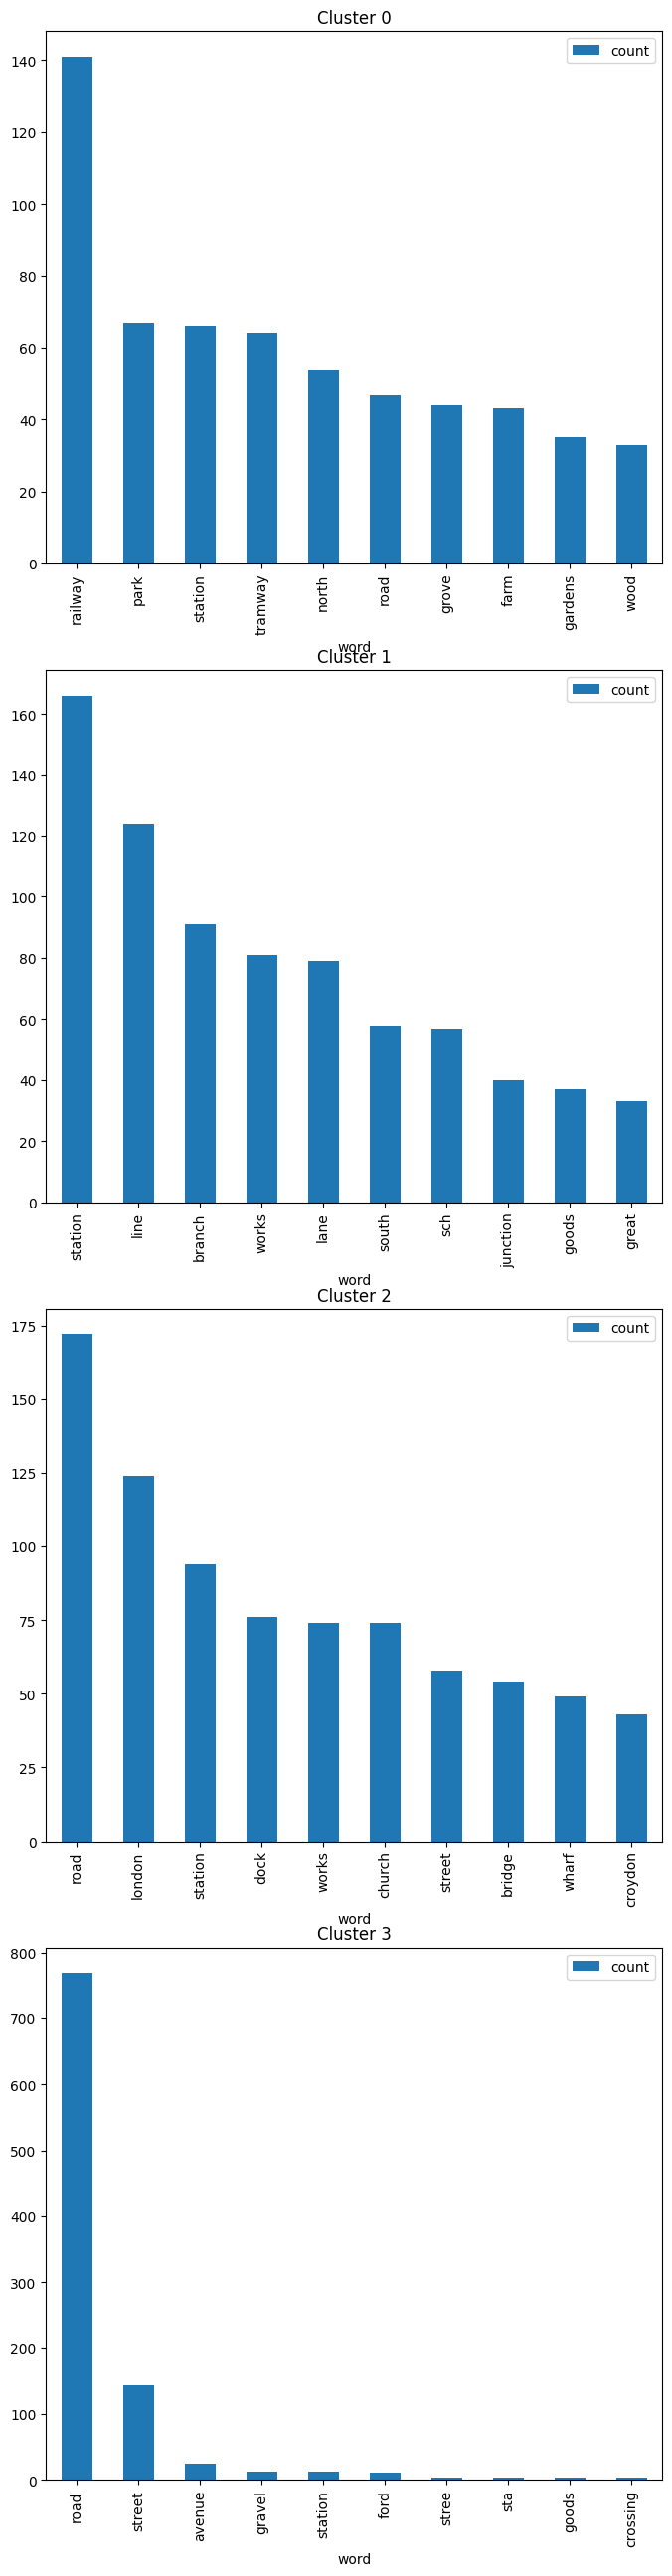

In [90]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=len(cluster_labels.index), ncols=1, figsize=(8, 8*len(cluster_labels.index)))

cluster_dataframes = {}

for cluster in cluster_labels.index:
	cluster_dataframes[cluster] = pd.DataFrame(Counter(cluster_labels.iloc[cluster]["words"]).most_common(10), columns=["word", "count"])
	cluster_dataframes[cluster].plot(kind='bar', x='word', y='count', title=f'Cluster {cluster}', legend=True, ax=ax[cluster])

fig.show()

In [92]:
patches_per_cluster = predictions_red_red['cluster'].value_counts()
print(patches_per_cluster)

cluster
1    3261
2    2333
0    1185
3     956
Name: count, dtype: int64


## 10b Cluster with patch + context text

In [93]:
# 10.1 Create 'sentences' of railspace labels in patches

# important this cell takes a while to run
# you can simply ignore and load the json file I've shared with you
tqdm.pandas()
adjacent_texts_context = [] 

for i,row in tqdm(predictions_red.iterrows(), total=predictions_red.shape[0]):
	# get context polygon
	minx, miny, maxx, maxy = row.geometry.bounds
	context_polygon = Polygon.from_bounds(minx-100, miny-100, maxx+100, maxy+100)
	# get text within a certain distance from the patch
	# get the set of text labels
	labels_patch_context = list(set(spotted_text_filtered[spotted_text_filtered.intersects(context_polygon)].text_cleaned.tolist()))
	# sort
	labels_patch_context = sorted(labels_patch_context)
	# add the labels as a list sorted alphabetically
	adjacent_texts_context.append(labels_patch_context)

with open('adjacent_texts_context.json', 'w') as out_txt:
	json.dump(adjacent_texts_context, out_txt)

100%|██████████| 29395/29395 [03:28<00:00, 140.77it/s]


In [95]:
# load the labels from json
with open('adjacent_texts_context.json', 'r') as in_txt:
    adjacent_texts_context = json.load(in_txt)

In [96]:
def filter_adjacent_texts(text):
	text = [w for w in text if len(w) > 2 and w.isalpha()]
	return text if len(text) > 0 else None

predictions_red["adjacent_texts_context"] = adjacent_texts_context
predictions_red["adjacent_texts_context"] = predictions_red["adjacent_texts_context"].apply(filter_adjacent_texts)

predictions_red_red_context = predictions_red[predictions_red["adjacent_texts_context"].notnull()].copy(deep=True)

In [98]:
# 10.2 filter the list to remove short and non-alphabetic labels

# this is not ideal as it remove abbreviations and other useful information
# especially in the more denser urban areas, however we use it as a simple experiment
adjacent_texts_red_context = predictions_red_red_context["adjacent_texts_context"].to_list()
labels_sentence_context = [' '.join([w for w in a if (len(w) > 2) and w.isalpha()]) for a in adjacent_texts_red_context]

In [99]:
# get the average number of words on a patch

np.mean([len(i) for i in labels_sentence_context])

26.24052805820084

In [100]:
# 10.3 load the embedding model

model = SentenceTransformer('distilbert-base-nli-mean-tokens') # Livingwithmachines/bert_1760_1900 | distilbert-base-nli-mean-tokens
# encode the railspace "sentences", i.e. the list of alphabetically sorted labels

# Note to self: avoid 'sentence'. say set of (alphabetically sorted) spotted text on patch. 
# now, for each set of patchText, we examine how similar they are to each other and organise them into a (pre-determined) number of 'clusters' 
# e.g. a cluster is a group of sets of patchText that are most like each other

railspace_sentence_embeddings_context = model.encode(labels_sentence_context)

In [101]:
railspace_sentence_embeddings_context.shape, predictions_red_red_context.shape

((24467, 768), (24467, 21))

In [102]:

# 10.4 fit the kmeans model to the railspace embeddings

# we choose a method of clustering as one approach among many to organise the data, to see patterns in the data
# this is connecting what we know about text and what we know about visual features on maps for the first time
# we can use the silhouette score to evaluate the quality of the clustering - best is 1, worst is -1

from sklearn.metrics import silhouette_score
cluster_data_context = {}

for n in tqdm(range(4,7)):
	cluster_data_context[n] = {}
	# fit the kmeans model
	kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto", max_iter=1000).fit(railspace_sentence_embeddings_context)
	cluster_data_context[n]["kmeans"] = kmeans
	# get the silhouette score
	silhouette = silhouette_score(railspace_sentence_embeddings_context, kmeans.labels_, random_state=0)
	cluster_data_context[n]["silhouette"] = silhouette


100%|██████████| 3/3 [00:36<00:00, 12.19s/it]


In [103]:
sorted_kmeans_context = pd.DataFrame(cluster_data_context).T.sort_values("silhouette", ascending=False)
sorted_kmeans_context.head()

,kmeans,silhouette
6,"KMeans(max_iter=1000, n_clusters=6, random_sta...",0.037867
5,"KMeans(max_iter=1000, n_clusters=5, random_sta...",0.035664
4,"KMeans(max_iter=1000, n_clusters=4, random_sta...",0.030662


In [104]:
best_kmeans_context = sorted_kmeans_context.loc[4]["kmeans"]

In [107]:
# add labels to the predictions_red dataframe

predictions_red_red_context['cluster_context'] = best_kmeans_context.labels_
predictions_red_red_context['labels_context'] = labels_sentence_context

In [ ]:
# 10.5 plot the different clusters on the map

predictions_red_red_context.explore(column='cluster_context', tiles=tiles, categorical=True, cmap="viridis", popup=['cluster_context', 'labels_context'])

In [109]:
x, y = [i[0] for i in predictions_red.to_crs("EPSG:4326").unary_union.centroid.xy]

In [110]:
import folium
import io
from PIL import Image

In [111]:
maps_context = []
for cluster in predictions_red_red_context["cluster_context"].unique():
	m = folium.Map(location=[y, x], zoom_start=9, tiles=tiles)
	predictions_red_red_context[predictions_red_red_context["cluster_context"] == cluster].explore(color="blue", marker_kwargs={"radius":1}, style_kwargs={"weight":1, "fillColor": "blue", "fillOpacity":1}, m=m)

	m.save(f"text_cluster_{cluster}_context.html")

	maps_context.append(m)

In [112]:
for cluster in predictions_red_red_context["cluster_context"].unique():
	# f = f"20sample_cluster_{cluster}_mean_pixel_RGB.csv"
	# cluster_df = predictions_red[predictions_red["cluster"] == cluster].sample(20, weights="mean_pixel_RGB", random_state=42)
	# cluster_df["image_id"].to_csv(f)
	
	cluster_df = predictions_red_red_context[predictions_red_red_context["cluster_context"] == cluster].copy(deep=True)
	cluster_df["polygon"] = cluster_df["polygon"].apply(to_wkt)
	cluster_df["centroid"] = cluster_df["centroid"].apply(to_wkt)
	cluster_df.to_file(f"cluster_{cluster}_context.geojson", driver="GeoJSON")

	with open(f"20sample_cluster_{cluster}_context_random.txt", "w") as f:
		f.writelines("\n".join(cluster_df["image_id"].sample(20, random_state=42).to_list()))

10.6 Understanding Clusters

The cells below contain different ways of looking at the clusters

In [113]:
#get labels for each cluster in predictions_red
cluster_labels_context = predictions_red_red_context.groupby('cluster_context')['labels_context'].apply(list).reset_index()
cluster_labels_context

,cluster_context,labels_context
0,0,"[beadon hammersmith king sta street west, bead..."
1,1,"[cour earks erhibition grounds, cour earks erh..."
2,2,[floating fulham hurlingham pier wharf wharves...
3,3,"[king road, dryburgh egliston road, dryburgh r..."


In [114]:
#count labels per cluster
cluster_labels_context['count'] = cluster_labels_context['labels_context'].apply(lambda x: len(x))
cluster_labels_context

,cluster_context,labels_context,count
0,0,"[beadon hammersmith king sta street west, bead...",8656
1,1,"[cour earks erhibition grounds, cour earks erh...",6121
2,2,[floating fulham hurlingham pier wharf wharves...,4421
3,3,"[king road, dryburgh egliston road, dryburgh r...",5269


In [115]:
# count unique labels per cluster
cluster_labels_context['unique_count'] = cluster_labels_context['labels_context'].apply(lambda x: len(set(x)))
cluster_labels_context

,cluster_context,labels_context,count,unique_count
0,0,"[beadon hammersmith king sta street west, bead...",8656,6520
1,1,"[cour earks erhibition grounds, cour earks erh...",6121,2060
2,2,[floating fulham hurlingham pier wharf wharves...,4421,2900
3,3,"[king road, dryburgh egliston road, dryburgh r...",5269,3649


In [116]:
cluster_labels_context["count/unique_count"] = cluster_labels_context["count"]/cluster_labels_context["unique_count"]
cluster_labels_context["unique_count/count"] = cluster_labels_context["unique_count"]/cluster_labels_context["count"]
cluster_labels_context

,cluster_context,labels_context,count,unique_count,count/unique_count,unique_count/count
0,0,"[beadon hammersmith king sta street west, bead...",8656,6520,1.327607,0.753235
1,1,"[cour earks erhibition grounds, cour earks erh...",6121,2060,2.971359,0.336546
2,2,[floating fulham hurlingham pier wharf wharves...,4421,2900,1.524483,0.655960
3,3,"[king road, dryburgh egliston road, dryburgh r...",5269,3649,1.443957,0.692541


In [117]:
cluster_labels_context["labels_2"] = cluster_labels_context["labels_context"].apply(lambda x: [word if len(word) else "NONE" for word in x])
cluster_labels_context["words"] = cluster_labels_context["labels_2"].apply(lambda x: " ".join(x).split())
cluster_labels_context

,cluster_context,labels_context,count,unique_count,count/unique_count,unique_count/count,labels_2,words
0,0,"[beadon hammersmith king sta street west, bead...",8656,6520,1.327607,0.753235,"[beadon hammersmith king sta street west, bead...","[beadon, hammersmith, king, sta, street, west,..."
1,1,"[cour earks erhibition grounds, cour earks erh...",6121,2060,2.971359,0.336546,"[cour earks erhibition grounds, cour earks erh...","[cour, earks, erhibition, grounds, cour, earks..."
2,2,[floating fulham hurlingham pier wharf wharves...,4421,2900,1.524483,0.655960,[floating fulham hurlingham pier wharf wharves...,"[floating, fulham, hurlingham, pier, wharf, wh..."
3,3,"[king road, dryburgh egliston road, dryburgh r...",5269,3649,1.443957,0.692541,"[king road, dryburgh egliston road, dryburgh r...","[king, road, dryburgh, egliston, road, dryburg..."


/var/folders/fn/j7v8jkl1717c1b6sy_sr0szc0000gr/T/ipykernel_70116/2331859209.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


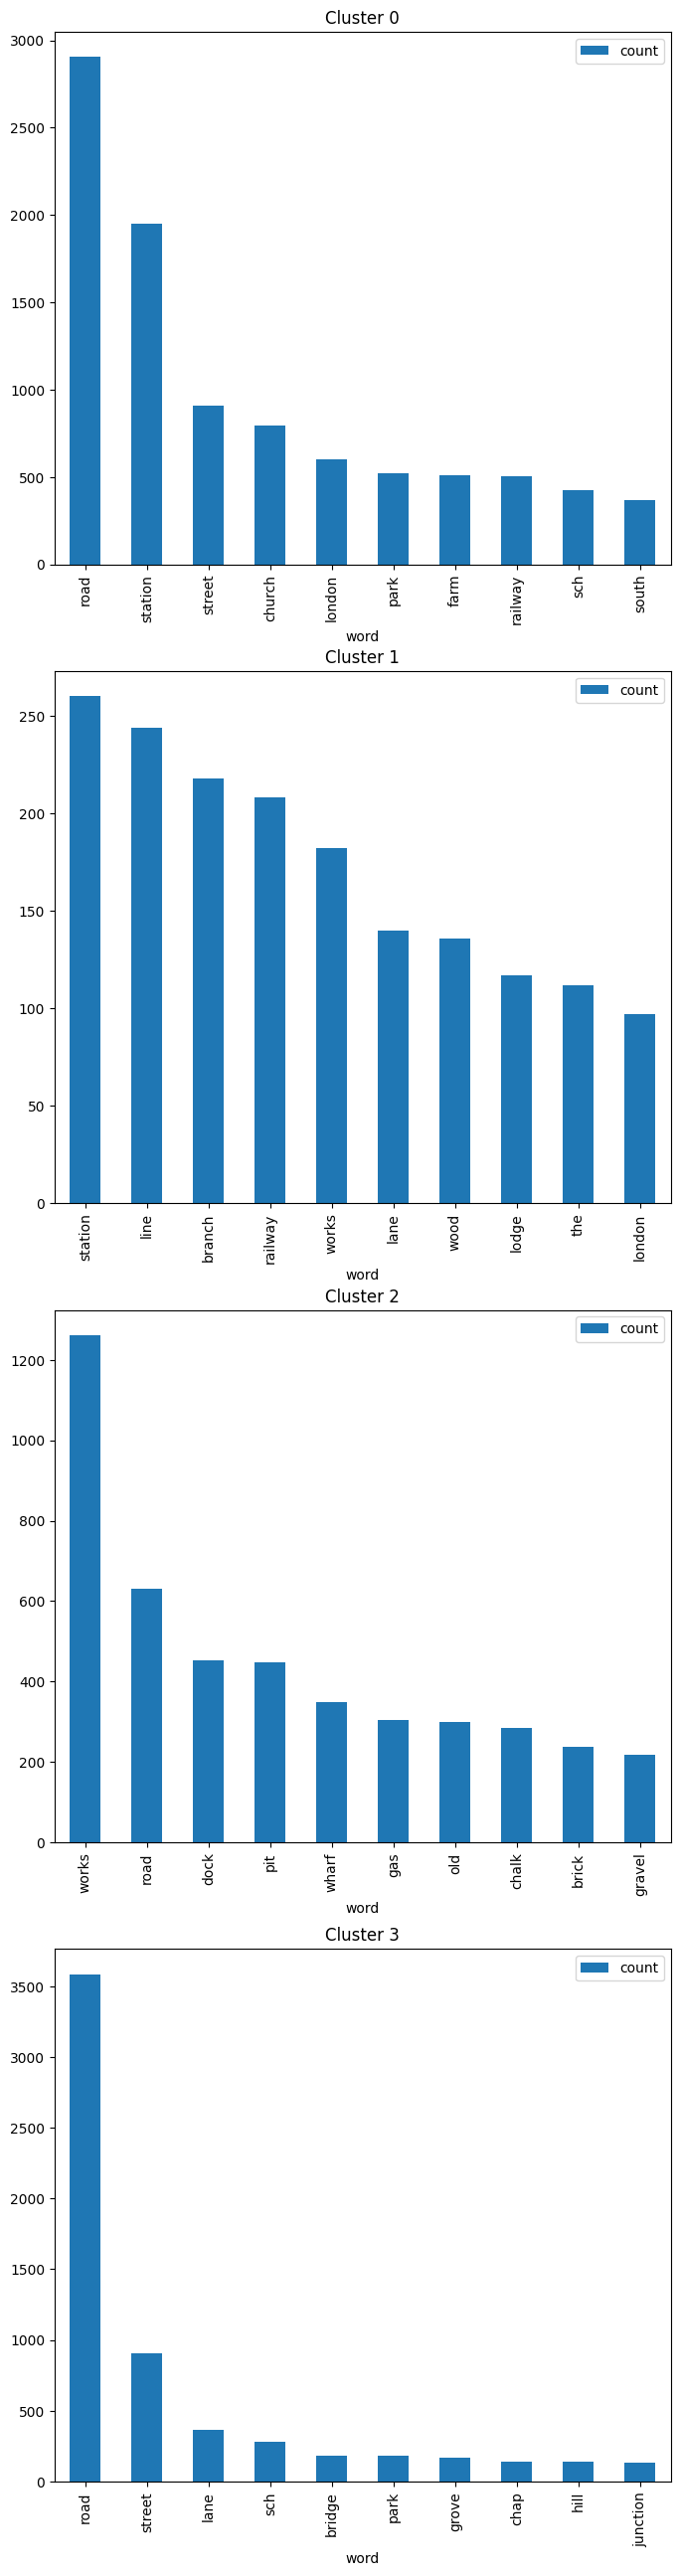

In [118]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=len(cluster_labels_context.index), ncols=1, figsize=(8, 8*len(cluster_labels_context.index)))

cluster_dataframes = {}

for cluster in cluster_labels_context.index:
	cluster_dataframes[cluster] = pd.DataFrame(Counter(cluster_labels_context.iloc[cluster]["words"]).most_common(10), columns=["word", "count"])
	cluster_dataframes[cluster].plot(kind='bar', x='word', y='count', title=f'Cluster {cluster}', legend=True, ax=ax[cluster])

fig.show()

In [119]:
patches_per_cluster = predictions_red_red_context['cluster_context'].value_counts()
print(patches_per_cluster)

cluster_context
0    8656
1    6121
3    5269
2    4421
Name: count, dtype: int64


# Fin.